In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, signal
from numpy import sign, array, where
from scipy.interpolate import UnivariateSpline
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931, plot_chromaticity_diagram_CIE1931, XYZ_to_plotting_colourspace
from colour.colorimetry import RGB_ColourMatchingFunctions, SpectralDistribution, sd_to_XYZ

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

import matplotlib.patheffects as pe

In [3]:
def FWHM(X,Y):
    half_max = max(Y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = Y - half_max
    #plot(X[0:len(d)],d) #if you are interested
    #find the left and right most indexes
    indices = np.where(d>0)
    return (X[indices[0]-1]-820)/20, (X[indices[-1]+1]-820)/20, half_max, [X[indices[0]-1],X[indices[-1]+1]]

In [4]:
def improved_FWHM(X,Y, wl_min = 820, wl_max = 840):
    half_max = max(Y)/2.0
    Spline = UnivariateSpline(X,Y - half_max, s = 0)
    r1,r2 = Spline.roots()
    return (r1-wl_min)/(wl_max - wl_min), (r2-wl_min)/(wl_max - wl_min), half_max, r2-r1

In [5]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return [R,G,B]

In [6]:
wavelengths = np.linspace(200,1000,1000)
count_range = np.linspace(0,100000,5)
WL, COUNT = np.meshgrid(count_range, wavelengths)
colorgrid = [[wavelength_to_rgb(wav) for i in count_range] for wav in wavelengths]
WL.shape

(1000, 5)

In [7]:
PI_df = pd.read_excel("UVB LAB DATA.xlsx",sheet_name="Module 2", skiprows=2)

In [8]:
# Linear regression
res1 = stats.linregress(PI_df.loc[PI_df["Current (mA)"].notnull(), "Current (mA)"][6:], PI_df.loc[PI_df["Current (mA)"].notnull(), "Power (mW)"][6:])

res2 = stats.linregress(PI_df.loc[PI_df["Current (mA).1"].notnull(), "Current (mA).1"][6:], PI_df.loc[PI_df["Current (mA).1"].notnull(), "Power (mW).1"][6:])

res3 = stats.linregress(PI_df.loc[PI_df["Current (mA).2"].notnull(), "Current (mA).2"][6:], PI_df.loc[PI_df["Current (mA).2"].notnull(), "Power (mW).2"][6:])

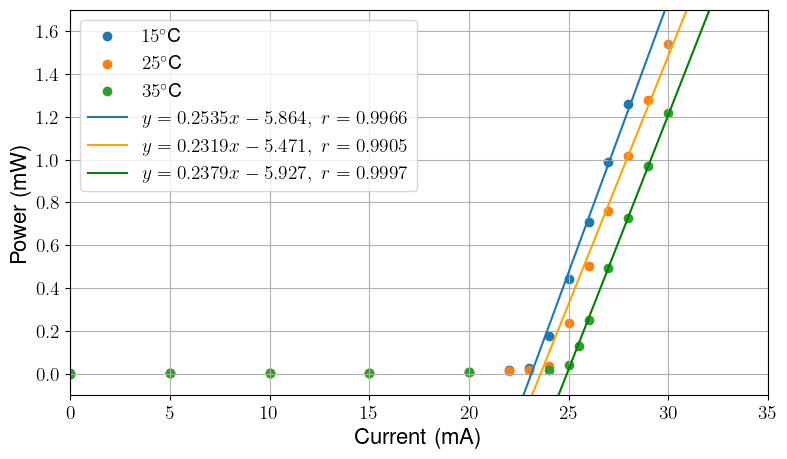

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (9,5))

ax.scatter(PI_df["Current (mA)"], PI_df["Power (mW)"])
ax.scatter(PI_df["Current (mA).1"], PI_df["Power (mW).1"])
ax.scatter(PI_df["Current (mA).2"], PI_df["Power (mW).2"])
ax.axline((0,res1.intercept), slope=res1.slope)
ax.axline((0,res2.intercept), slope=res2.slope, color = "orange")
ax.axline((0,res3.intercept), slope=res3.slope, color = "green")
ax.grid(True)
ax.set_xlabel("Current (mA)", fontsize = 16)
ax.set_ylabel("Power (mW)", fontsize = 16)
ax.legend(["$15^\circ$C", "$25^\circ$C", "$35^\circ$C", "$y = 0.2535x - 5.864,\; r = 0.9966$", "$y = 0.2319x - 5.471,\; r = 0.9905$", "$y = 0.2379x - 5.927,\; r = 0.9997$"], fontsize = 14)
ax.tick_params("both", labelsize = 14)
ax.set_xlim([0, 35])
ax.set_ylim([-0.1,1.7])

plt.show()

In [10]:
def str2float(dataframe):
    for i, row in dataframe.iterrows():
        #print(dataframe["[nm]   "][i].strip().replace(",","."))
        dataframe["[nm]   "][i] = float(dataframe["[nm]   "][i].strip().replace(",","."))
        
        try:
            dataframe["[counts] "][i] = float(dataframe["[counts] "][i].strip().strip("-").replace(",","."))
        except:
            pass
        
    return dataframe

In [11]:
LD_spectrum15 = str2float(pd.read_table("./data/15deg_40mA_LD_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value=np.NaN))
LD_spectrum15_clean = LD_spectrum15.loc[LD_spectrum15["[counts] "].notnull()].reset_index()

LD_spectrum25 = str2float(pd.read_table("./data/25deg_40mA_LD_0901140U1_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value=np.NaN))
LD_spectrum25_clean = LD_spectrum25.loc[LD_spectrum25["[counts] "].notnull()].reset_index()

LD_spectrum35 = str2float(pd.read_table("./data/35deg_40mA_LD_0901140U1_0901140U1_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value=np.NaN))
LD_spectrum35_clean = LD_spectrum35.loc[LD_spectrum35["[counts] "].notnull()].reset_index()

In [12]:
LD_wl1 = np.array(LD_spectrum15_clean["[nm]   "],dtype=np.float64)
LD_count1 = np.array(LD_spectrum15_clean["[counts] "], dtype=np.float64)
LD_wl2 = np.array(LD_spectrum25_clean["[nm]   "],dtype=np.float64)
LD_count2 = np.array(LD_spectrum25_clean["[counts] "], dtype=np.float64)
LD_wl3 = np.array(LD_spectrum35_clean["[nm]   "],dtype=np.float64)
LD_count3 = np.array(LD_spectrum35_clean["[counts] "], dtype=np.float64)
#np.float64(LD_wl1[83].strip().replace(",","."))

In [13]:
left1, right1, fwhm1, lw1 = improved_FWHM(LD_wl1, LD_count1)
left2, right2, fwhm2, lw2 = improved_FWHM(LD_wl2, LD_count2)
left3, right3, fwhm3, lw3 = improved_FWHM(LD_wl3, LD_count3)
print(f"Linewidth 15 deg: {lw1} nm")
print(f"Linewidth 25 deg: {lw2} nm")
print(f"Linewidth 35 deg: {lw3} nm")

Linewidth 15 deg: 1.8019303456848093 nm
Linewidth 25 deg: 2.107066177460979 nm
Linewidth 35 deg: 1.7263055351215826 nm


In [14]:
print(LD_wl1[np.argmax(LD_count1)])
print(LD_wl2[np.argmax(LD_count2)])
print(LD_wl3[np.argmax(LD_count3)])

826.0
828.0
831.0


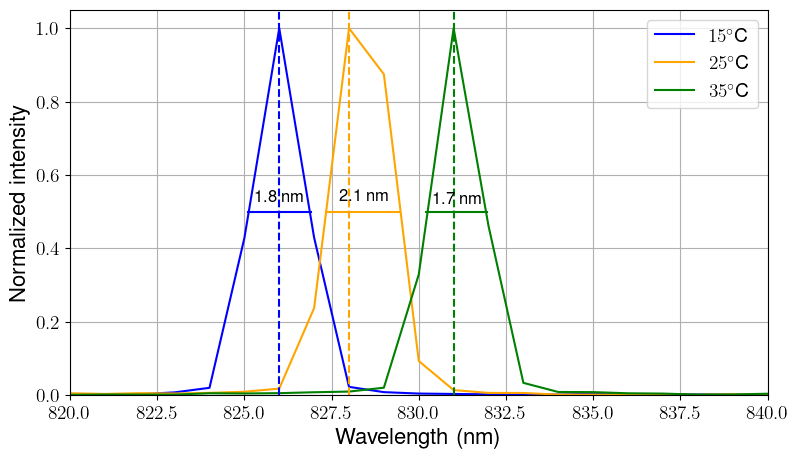

In [15]:
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(9,5))

ax2.plot(LD_wl1, LD_count1/max(LD_count1), color = "blue")
ax2.plot(LD_wl2, LD_count2/max(LD_count2), color = "orange")
ax2.plot(LD_wl3, LD_count3/max(LD_count3), color = "green")
ax2.axhline(fwhm1/max(LD_count1), xmin=left1, xmax=right1, linestyle = "-", color = "blue")
ax2.axhline(fwhm2/max(LD_count2), xmin=left2, xmax=right2, linestyle = "-", color = "orange")
ax2.axhline(fwhm3/max(LD_count3), xmin=left3, xmax=right3, linestyle = "-", color = "green")
ax2.text(825.3, 2575/max(LD_count1), "1.8 nm", fontsize = 12)
ax2.text(827.72, 1900/max(LD_count2), "2.1 nm", fontsize = 12)
ax2.text(830.42, 2825/max(LD_count3), "1.7 nm", fontsize = 12)
ax2.axvline(LD_wl1[np.argmax(LD_count1)], linestyle = "--", color = "blue")
ax2.axvline(LD_wl2[np.argmax(LD_count2)], linestyle = "--", color = "orange")
ax2.axvline(LD_wl3[np.argmax(LD_count3)], linestyle = "--", color = "green")
ax2.grid(True)
ax2.set_xlabel("Wavelength (nm)", fontsize = 16)
ax2.set_ylabel("Normalized intensity", fontsize = 16)
ax2.tick_params("both", labelsize = 14)
ax2.legend(["$15^\circ$C", "$25^\circ$C", "$35^\circ$C"], fontsize = 14)
ax2.set_xlim([820,840])
ax2.set_ylim([-0.00,1.05])

plt.savefig('./Image_res/Diode_laser_spectrum.svg', format = 'svg', dpi = 1200)

plt.show()

In [16]:
blue_LED = str2float(pd.read_table("./data/blue_LED_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value = np.NaN))
blue_LED_clean = blue_LED.loc[blue_LED["[counts] "].notnull()].reset_index()
green_LED = str2float(pd.read_table("./data/green_LED_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value = np.NaN))
green_LED_clean = green_LED.loc[green_LED["[counts] "].notnull()].reset_index()
yellow_LED = str2float(pd.read_table("./data/yellow_LED_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value = np.NaN))
yellow_LED_clean = yellow_LED.loc[yellow_LED["[counts] "].notnull()].reset_index()

In [17]:
blue_LED_wl = np.array(blue_LED_clean["[nm]   "], dtype=np.float64)
blue_LED_count = np.array(blue_LED_clean["[counts] "], dtype=np.float64)
green_LED_wl = np.array(green_LED_clean["[nm]   "], dtype=np.float64)
green_LED_count = np.array(green_LED_clean["[counts] "], dtype=np.float64)
yellow_LED_wl = np.array(yellow_LED_clean["[nm]   "], dtype=np.float64)
yellow_LED_count = np.array(yellow_LED_clean["[counts] "], dtype=np.float64)

In [18]:
blue_LED_left, blue_LED_right, blue_LED_fwhm, blue_LED_lw = improved_FWHM(blue_LED_wl, blue_LED_count, wl_min=400, wl_max=700)
green_LED_left, green_LED_right, green_LED_fwhm, green_LED_lw = improved_FWHM(green_LED_wl, green_LED_count, wl_min=400, wl_max=700)
yellow_LED_left, yellow_LED_right, yellow_LED_fwhm, yellow_LED_lw = improved_FWHM(yellow_LED_wl, yellow_LED_count, wl_min=400, wl_max=700)
print(f"Linewidth blue LED deg: {blue_LED_lw} nm")
print(f"Linewidth green LED deg: {green_LED_lw} nm")
print(f"Linewidth yellow LED deg: {yellow_LED_lw} nm")

Linewidth blue LED deg: 26.90215408958892 nm
Linewidth green LED deg: 36.53494809983874 nm
Linewidth yellow LED deg: 12.314039422036672 nm


In [20]:
print(blue_LED_wl[np.argmax(blue_LED_count)])
print(green_LED_wl[np.argmax(green_LED_count)])
print(yellow_LED_wl[np.argmax(yellow_LED_count)])

468.0
529.0
590.0


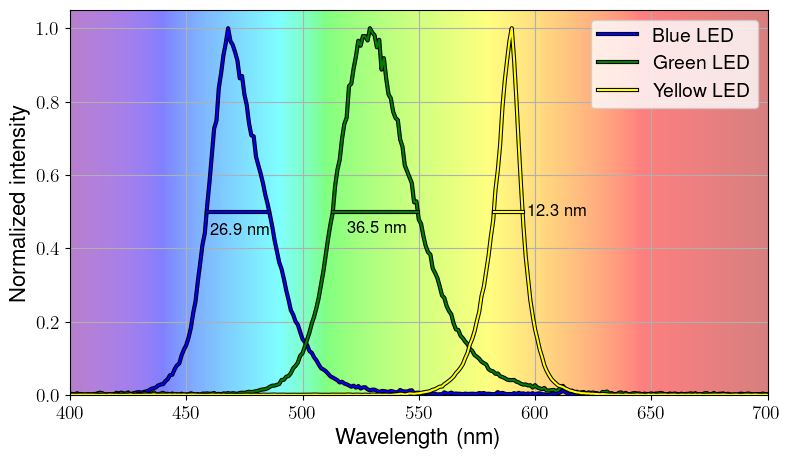

In [57]:
fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize = (9,5))

ax3.plot(blue_LED_wl, blue_LED_count/max(blue_LED_count), color = "blue", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax3.plot(green_LED_wl, green_LED_count/max(green_LED_count), color = "green", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax3.plot(yellow_LED_wl, yellow_LED_count/max(yellow_LED_count), color = "yellow", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax3.axhline(y = blue_LED_fwhm/max(blue_LED_count), xmin= blue_LED_left, xmax=blue_LED_right, color = "blue", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax3.axhline(y = green_LED_fwhm/max(green_LED_count), xmin= green_LED_left, xmax=green_LED_right, color = "green", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax3.axhline(y = yellow_LED_fwhm/max(yellow_LED_count), xmin= yellow_LED_left, xmax=yellow_LED_right, color = "yellow", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax3.text(460, 1500/max(blue_LED_count), "26.9 nm", fontsize = 12)
ax3.text(519, 1550/max(green_LED_count), "36.5 nm", fontsize = 12)
ax3.text(597, 6350/max(yellow_LED_count), "12.3 nm", fontsize = 12)
ax3.legend(["Blue LED", "Green LED", "Yellow LED"], fontsize = 14)
ax3.grid(True)
ax3.set_xlabel("Wavelength (nm)", fontsize = 16)
ax3.set_ylabel("Normalized intensity", fontsize = 16)
ax3.tick_params("both", labelsize = 14)
ax3.set_xlim([400,700])
ax3.set_ylim([0,1.05])
ax3.pcolormesh(COUNT, WL, colorgrid, alpha = 0.5)

plt.savefig('./Image_res/Color_LED_spectrum.svg', format = 'svg', dpi = 1200)

plt.show()

In [58]:
white_LED = str2float(pd.read_table("./data/white_LED_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value = np.NaN))
white_LED_clean = white_LED.loc[white_LED["[counts] "].notnull()].reset_index()
blue_filter = str2float(pd.read_table("./data/blue_filter_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value = np.NaN))
blue_filter_clean = blue_filter.loc[blue_filter["[counts] "].notnull()].reset_index()
bluegreen_filter = str2float(pd.read_table("./data/blue_green_filter_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value = np.NaN))
bluegreen_filter_clean = bluegreen_filter.loc[bluegreen_filter["[counts] "].notnull()].reset_index()
green_filter = str2float(pd.read_table("./data/green_filter_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value = np.NaN))
green_filter_clean = green_filter.loc[green_filter["[counts] "].notnull()].reset_index()
red_filter = str2float(pd.read_table("./data/red_filter_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value = np.NaN))
red_filter_clean = red_filter.loc[red_filter["[counts] "].notnull()].reset_index()
yellow_filter = str2float(pd.read_table("./data/yellow_filter_not_working_0901140U1.TXT", skiprows=6, delimiter=";").replace(to_replace="   Not Available", value = np.NaN))
yellow_filter_clean = yellow_filter.loc[yellow_filter["[counts] "].notnull()].reset_index()

In [59]:
white_LED_wl = np.array(white_LED_clean["[nm]   "], dtype=np.float64)
white_LED_count = np.array(white_LED_clean["[counts] "], dtype=np.float64)
blue_filter_wl = np.array(blue_filter_clean["[nm]   "], dtype=np.float64)
blue_filter_count = np.array(blue_filter_clean["[counts] "], dtype=np.float64)
bluegreen_filter_wl = np.array(bluegreen_filter_clean["[nm]   "], dtype=np.float64)
bluegreen_filter_count = np.array(bluegreen_filter_clean["[counts] "], dtype=np.float64)
green_filter_wl = np.array(green_filter_clean["[nm]   "], dtype=np.float64)
green_filter_count = np.array(green_filter_clean["[counts] "], dtype=np.float64)
red_filter_wl = np.array(red_filter_clean["[nm]   "], dtype=np.float64)
red_filter_count = np.array(red_filter_clean["[counts] "], dtype=np.float64)
yellow_filter_wl = np.array(yellow_filter_clean["[nm]   "], dtype=np.float64)
yellow_filter_count = np.array(yellow_filter_clean["[counts] "], dtype=np.float64)

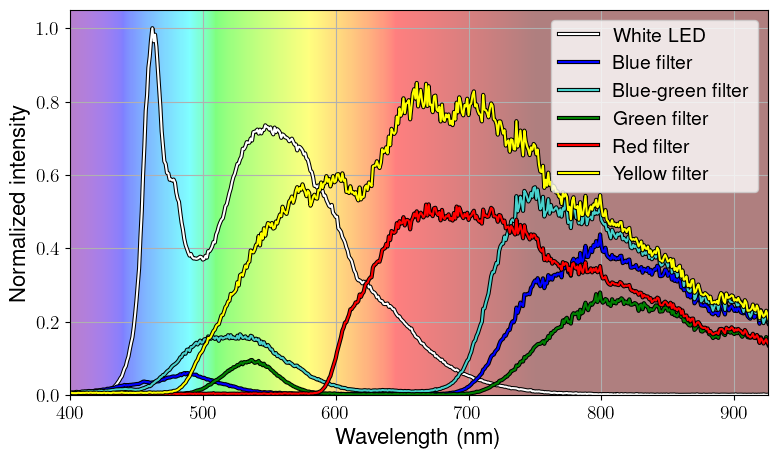

In [62]:

fig4, ax4 = plt.subplots(nrows=1, ncols=1, figsize = (9,5))

ax4.plot(white_LED_wl, white_LED_count/max(white_LED_count), color = "white", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax4.plot(blue_filter_wl, blue_filter_count/max(white_LED_count), color = "blue", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax4.plot(bluegreen_filter_wl, bluegreen_filter_count/max(white_LED_count), color = "mediumturquoise", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax4.plot(green_filter_wl, green_filter_count/max(white_LED_count), color = "green", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax4.plot(red_filter_wl, red_filter_count/max(white_LED_count), color = "red", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax4.plot(yellow_filter_wl, yellow_filter_count/max(white_LED_count), color = "yellow", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax4.legend(["White LED", "Blue filter", "Blue-green filter", "Green filter", "Red filter", "Yellow filter"], fontsize = 14)
ax4.grid(True)
ax4.set_xlabel("Wavelength (nm)", fontsize = 16)
ax4.set_ylabel("Normalized intensity", fontsize = 16)
ax4.tick_params("both", labelsize = 14)
ax4.set_xlim([400,925])
ax4.set_ylim([0,1.05])
ax4.pcolormesh(COUNT, WL, colorgrid, alpha = 0.5)

plt.savefig('./Image_res/White_LED_spectrum.svg', format = 'svg', dpi = 1200)


plt.show()

In [23]:
def normalize_coor(coor):
    return np.array(coor)/np.sum(coor)

In [24]:
blue_coor = normalize_coor(sd_to_XYZ(SpectralDistribution({blue_LED_wl[i]:blue_LED_count[i] for i in range(len(blue_LED_wl)) if blue_LED_wl[i]>=360 and blue_LED_wl[i]<=750})))
green_coor = normalize_coor(sd_to_XYZ(SpectralDistribution({green_LED_wl[i]:green_LED_count[i] for i in range(len(green_LED_wl)) if green_LED_wl[i]>=360 and green_LED_wl[i]<=750})))
white_coor = normalize_coor(sd_to_XYZ(SpectralDistribution({white_LED_wl[i]:white_LED_count[i] for i in range(len(white_LED_wl)) if white_LED_wl[i]>=360 and white_LED_wl[i]<=750})))
yellow_coor = normalize_coor(sd_to_XYZ(SpectralDistribution({yellow_LED_wl[i]:yellow_LED_count[i] for i in range(len(yellow_LED_wl)) if yellow_LED_wl[i]>=360 and yellow_LED_wl[i]<=750})))

c:\Users\cahya\anaconda3\envs\jyu_learn\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
c:\Users\cahya\anaconda3\envs\jyu_learn\lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028


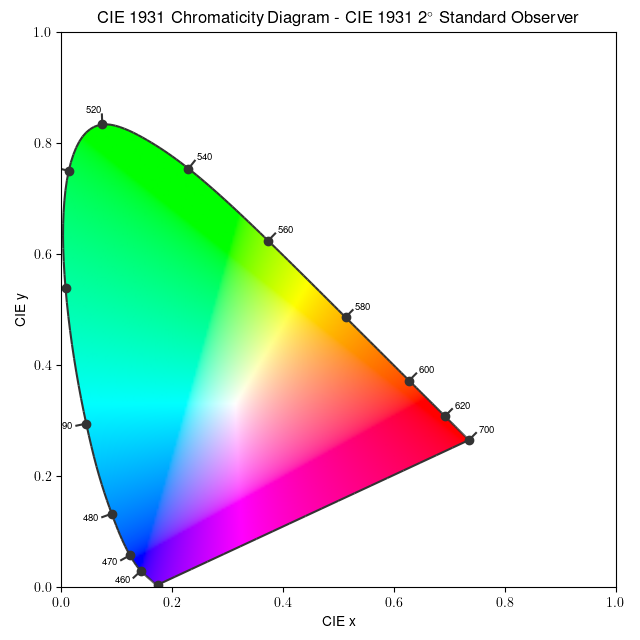

In [25]:
%matplotlib widget
plt.ion()
Fig_col, ax_col = plot_chromaticity_diagram_CIE1931(annotate_kwargs = {"fontsize": 12}, labelsize = 14,zorder = 3)
Fig_col.set_size_inches((5,5))
Fig_col.set_dpi(600)
ax_col.set_xlabel("X", fontsize = 12)
ax_col.set_ylabel("Y", fontsize = 12)
ax_col.tick_params('both', labelsize = 10)
ax_col.scatter(blue_coor[0], blue_coor[1], color = "blue", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()], label = "Blue LED")
ax_col.scatter(green_coor[0], green_coor[1], color = "green", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()], label = "Green LED")
ax_col.scatter(white_coor[0], white_coor[1], color = "white", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()], label = "White LED")
ax_col.scatter(yellow_coor[0], yellow_coor[1], color = "yellow", path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()], label = "Yellow LED")
ax_col.legend()
ax_col.set_title("")
#ax_col.grid(linestyle = "dashed", zorder = -1000)
ax_col.set_xlim((-0.07,0.8))
ax_col.set_ylim((-0.04,0.9))
ax_col.set_axisbelow(True)


In [26]:
print(blue_coor)
print(green_coor)
print(white_coor)
print(yellow_coor)

[ 0.12388905  0.10359683  0.77251412]
[ 0.2284037   0.71542777  0.05616853]
[ 0.32756138  0.40757434  0.26486429]
[ 0.55396593  0.44347927  0.0025548 ]
